In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%precision 3

'%.3f'

In [3]:
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
for dataset in df_train, df_test:
    dataset.drop(['Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

### 欠損値の補完、カテゴリ変数化

Age

In [6]:
df_train['Age'].mean()

29.699

In [7]:
df_train.groupby('Pclass').mean()['Age']

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

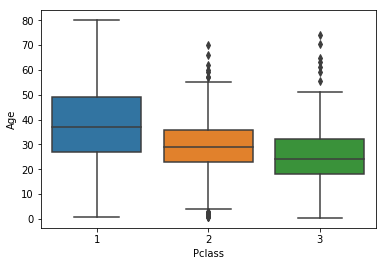

In [8]:
sns.boxplot(x='Pclass', y='Age', data=df_train)

In [9]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1: return 39
        if Pclass == 2: return 30
        else: return 25
    else:
        return Age

In [10]:
# 欠損値補完
for dataset in df_train, df_test:
    dataset['Age'] = dataset[['Age', 'Pclass']].apply(impute_age, axis = 1)

In [11]:
# カテゴリ変数化
for dataset in df_train, df_test:
    dataset['CategoricalAge'] = pd.qcut(dataset['Age'], 4, labels=False)

In [12]:
df_train['CategoricalAge'].value_counts()

0    231
1    224
3    218
2    218
Name: CategoricalAge, dtype: int64

Embarked

In [13]:
df_train[df_train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CategoricalAge
61,62,1,1,female,38.0,0,0,80.0,NaN,3
829,830,1,1,female,62.0,0,0,80.0,NaN,3


In [14]:
df_train.loc[df_train['PassengerId'].isin([62, 830]), 'Embarked'] = 'S'

In [15]:
df_train[df_train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CategoricalAge


Fare

In [16]:
df_train[['Pclass', 'Fare']].groupby('Pclass').mean()

,Fare
Pclass,
1,84.154687
2,20.662183
3,13.675550


In [17]:
df_test[df_test['Fare'].isnull()]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CategoricalAge
152,1044,3,male,60.5,0,0,NaN,S,3


In [18]:
df_test.loc[df_test['PassengerId'] == 1044, 'Fare'] = 13.675550

In [19]:
for dataset in df_train, df_test:
    dataset['CategoricalFare'] = pd.qcut(dataset['Fare'], 4, labels=False)

### IsAlone

In [20]:
for dataset in df_train, df_test:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in df_train, df_test:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

### 欠損値が残っていないかチェック

In [21]:
display(df_train.isnull().sum())
print('---')
display(df_test.isnull().sum())

PassengerId        0
Survived           0
Pclass             0
Sex                0
Age                0
SibSp              0
Parch              0
Fare               0
Embarked           0
CategoricalAge     0
CategoricalFare    0
FamilySize         0
IsAlone            0
dtype: int64

---


PassengerId        0
Pclass             0
Sex                0
Age                0
SibSp              0
Parch              0
Fare               0
Embarked           0
CategoricalAge     0
CategoricalFare    0
FamilySize         0
IsAlone            0
dtype: int64

### カテゴリ変数への変換

In [22]:
for dataset in df_train, df_test:
    dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1})

In [23]:
for dataset in df_train, df_test:
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# 学習

In [24]:
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CategoricalAge,CategoricalFare,FamilySize,IsAlone
0,1,0,3,0,22.0,1,0,7.2500,0,0,0,2,0
1,2,1,1,1,38.0,1,0,71.2833,1,3,3,2,0
2,3,1,3,1,26.0,0,0,7.9250,0,1,1,1,1
3,4,1,1,1,35.0,1,0,53.1000,0,2,3,2,0
4,5,0,3,0,35.0,0,0,8.0500,0,2,1,1,1


In [25]:
X_train = df_train.drop(['Survived', 'PassengerId', 'Age', 'SibSp', 'Parch', 'Fare'], axis=1)
y_train = df_train['Survived']
X_test = df_test.drop(['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare'], axis=1)

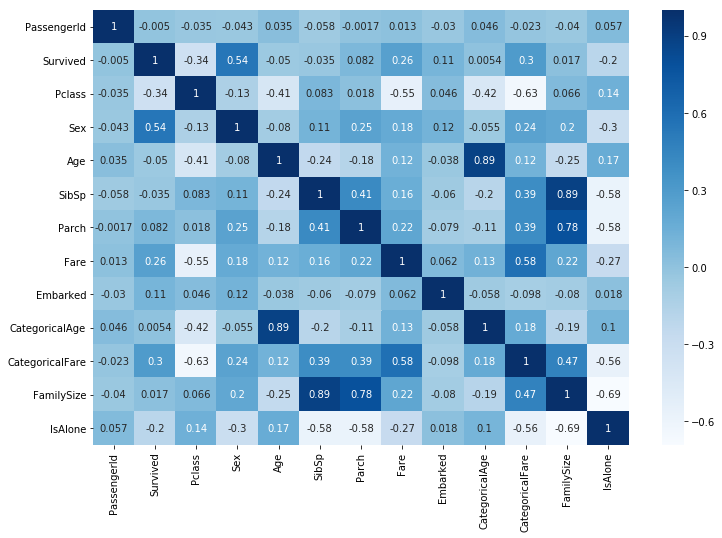

In [26]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_train.corr(), annot=True, cmap='Blues')

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [28]:
clfs = {'random_forest': RandomForestClassifier(random_state=0),
        'extra_trees': ExtraTreesClassifier(random_state=0),
        'ada_boost': AdaBoostClassifier(random_state=0),
        'gradient_boosting': GradientBoostingClassifier(random_state=0),
        'xgboost': XGBClassifier(random_state=0)
}

for k, clf in clfs.items():
    clf.fit(X_train, y_train)

In [29]:
for k, clf in clfs.items():
    print(clf.score(X_train, y_train))

0.8754208754208754
0.8787878787878788
0.8024691358024691
0.8462401795735129
0.8417508417508418


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [30]:
feature_dataframe = pd.DataFrame( {'features': X_train.columns,
                                   'RandomForest': clfs['random_forest'].feature_importances_,
                                   'ExtraTrees':  clfs['extra_trees'].feature_importances_,
                                   'AdaBoost': clfs['ada_boost'].feature_importances_,
                                   'GradiendBoostiong': clfs['gradient_boosting'].feature_importances_,
                                   'XGBoost': clfs['xgboost'].feature_importances_,
})

In [31]:
feature_dataframe

,features,RandomForest,ExtraTrees,AdaBoost,GradiendBoostiong,XGBoost
0,Pclass,0.142948,0.162634,0.24,0.103892,0.165123
1,Sex,0.383009,0.423370,0.06,0.173259,0.089506
2,Embarked,0.064634,0.054369,0.04,0.047466,0.070988
3,CategoricalAge,0.148578,0.110664,0.16,0.173357,0.189815
4,CategoricalFare,0.119211,0.111519,0.14,0.183290,0.226852
5,FamilySize,0.120961,0.099032,0.32,0.276375,0.257716
6,IsAlone,0.020659,0.038412,0.04,0.042362,0.000000


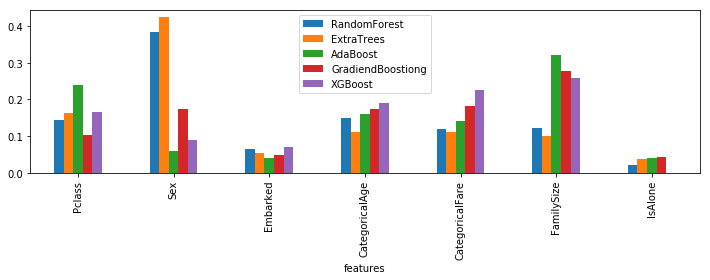

In [32]:
feature_dataframe.plot.bar(x='features', figsize=(12, 3))
# ref: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

# 交差検証

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [34]:
for k, clf in clfs.items():
    scores = cross_val_score(clf, X_train, y_train)
    print(f'{k:<18}: %s, average=%s' % (np.round(scores * 100, 1), round(scores.mean() *100, 1)))

random_forest     : [76.1 81.8 80.1], average=79.3
extra_trees       : [76.1 83.5 78.8], average=79.5
ada_boost         : [76.8 82.2 80.1], average=79.7
gradient_boosting : [78.5 84.8 80.1], average=81.1
xgboost           : [78.5 83.8 81.5], average=81.3


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [35]:
scores.mean()

0.8125701459034792

##### 層化k分割交差検証

In [36]:
kf = KFold(n_splits=3)

for k, clf in clfs.items():
    scores = cross_val_score(clf, X_train, y_train, cv=kf)
    print(f'{k:<18}: %s, average=%s' % (np.round(scores * 100, 1), round(scores.mean() * 100, 1)))

random_forest     : [76.8 81.8 79.5], average=79.3
extra_trees       : [76.8 81.5 79.1], average=79.1
ada_boost         : [77.8 81.1 79.8], average=79.6
gradient_boosting : [77.1 83.2 81.5], average=80.6
xgboost           : [78.5 82.5 81.5], average=80.8


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# 混同行列

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [38]:
X_train = df_train.drop(['Survived', 'PassengerId', 'Age', 'SibSp', 'Parch', 'Fare'], axis=1)
y_train = df_train['Survived']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.2)

In [40]:
clfs = {'random_forest': RandomForestClassifier(random_state=0),
        'extra_trees': ExtraTreesClassifier(random_state=0),
        'ada_boost': AdaBoostClassifier(random_state=0),
        'gradient_boosting': GradientBoostingClassifier(random_state=0),
        'xgboost': XGBClassifier(random_state=0)
}

matrix = []

for k, clf in clfs.items():
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_test)
    matrix.append(confusion_matrix(y_test.values, y_preds).reshape(1, 4).tolist()[0])

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [41]:
pd.DataFrame(matrix, index=clfs, columns=['TP', 'TN', 'FP', 'FN'])

,TP,TN,FP,FN
random_forest,96,7,18,58
extra_trees,96,7,23,53
ada_boost,88,15,16,60
gradient_boosting,94,9,17,59
xgboost,94,9,17,59


# GridSearch

In [42]:
from sklearn.model_selection import GridSearchCV

In [43]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

parameters = {
    'max_depth': [4, 5, 6, 7],
    'gamma': [0,5, 1, 2, 4, 10],
}

clf = XGBClassifier(random_state=0)

grid_search = GridSearchCV(clf, parameters, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_

In [44]:
best_clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=2, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [45]:
kf = KFold(n_splits=3)
scores = cross_val_score(best_clf, X_train, y_train, cv=kf)
print('%s, average=%s' % (np.round(scores * 100, 1), round(scores.mean() * 100, 1)))

[81.5 81.  74.7], average=79.1


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py

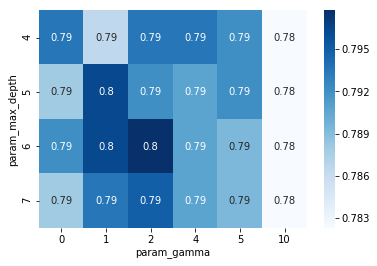

In [46]:
df_cv_results = pd.DataFrame(grid_search.cv_results_)
df_precision = df_cv_results.pivot(index='param_max_depth', columns='param_gamma', values='mean_test_score')
sns.heatmap(df_precision, annot=True, cmap='Blues')